## Setup

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

2022-10-07 17:07:42.165793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 17:07:42.314948: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-07 17:07:42.333017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 17:07:42.333039: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [3]:
def B_vs_V(x:np.array, y1:np.array, y2:np.array, y3:np.array):
    """plots y1, y2, and y3 vs x and returns the corresponding slopes"""
    index = x != 0 # Indexes for which v is non-zero
    x, y1, y2, y3 = x[index], y1[index], y2[index], y3[index] # Values for which v is non-zero

    # Plot
    fig, ax = plt.subplots()
    ax.plot(x, y1, label=r'$B_x$', linewidth=4.0)
    ax.plot(x, y2, label=r'$B_y$', linewidth=4.0)
    ax.plot(x, y3, label=r'$B_z$', linewidth=4.0)
    ax.set_xlabel(r'$V_1$ (arb. u.)')
    ax.set_ylabel('Field (arb. u.)' )
    #ax.set_xlim(0,1)
    ax.legend(loc=0)
    ax.grid()
    return ax

## Add non-linearity to individual voltage scans and see how it looks

Our electromagnet model provides linear relationship between the voltage and field. In order to explore non-linear relationship, we need to introduce non-linearity by hand.
We will do it  by applying tanh element-wise to the field values.

In [9]:
#Training data
df = pd.read_csv('data/individual_calibration_set.csv')

V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

V = np.stack((V1, V2, V3), axis=1)
M_ = np.loadtxt('data/lin_cal_mat.csv') #Calibration matrix
M = np.linalg.inv(M_) # Coefficient matrix
nf = 15 # Non-linearity factor

# Introduce non-linearity
Vn = np.tanh(V/nf)*10

B_nl = []

for v in Vn:
    B_nl.append(np.dot(M, v))

B_nl = np.array(B_nl)

## Plot non-linear data

<AxesSubplot: xlabel='$V_1$ (arb. u.)', ylabel='Field (arb. u.)'>

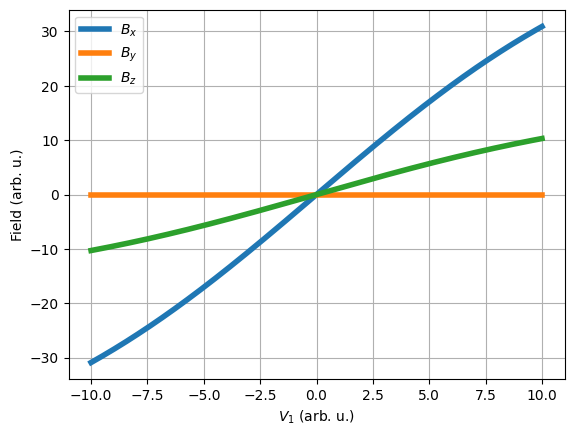

In [10]:
B_vs_V(V1, B_nl[:,0], B_nl[:,1], B_nl[:,2])

Text(0.5, 0, '$V_2$ (arb. u.)')

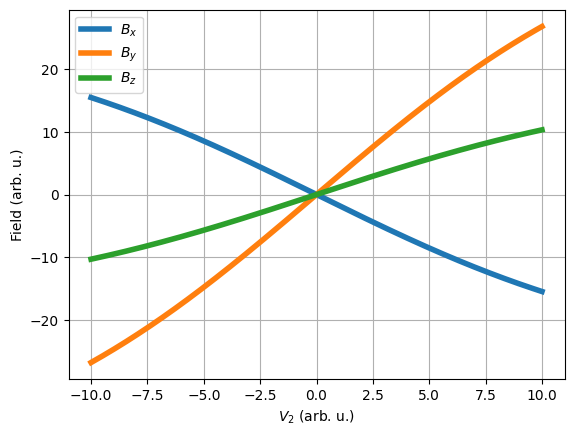

In [11]:
ax2 = B_vs_V(V2, B_nl[:,0], B_nl[:,1], B_nl[:,2])
ax2.set_xlabel(r'$V_2$ (arb. u.)')

Text(0.5, 0, '$V_3$ (arb. u.)')

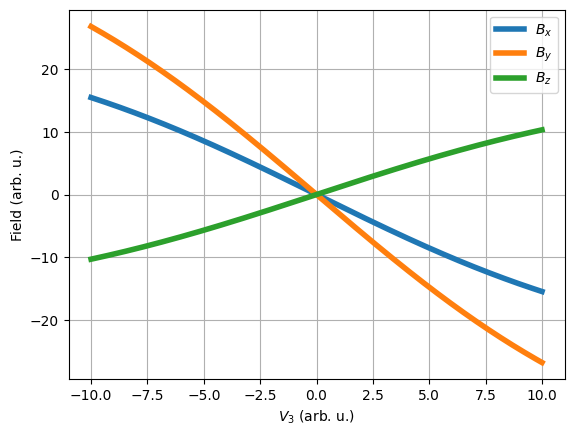

In [12]:
ax3 = B_vs_V(V3, B_nl[:,0], B_nl[:,1], B_nl[:,2])
ax3.set_xlabel(r'$V_3$ (arb. u.)')

## 'Deep' learning

### Load and prepare data

In [20]:
# Full calibration data
df = pd.read_csv('data/full_calibration_set.csv')

V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

# Stack data for the network
V_train = np.stack((V1, V2, V3), axis=1)

# Introduce non-linearity
Vn_train = np.tanh(V_train/nf)*10

B_train = []

for V in Vn_train:
    B_train.append(np.dot(M, V))

B_train = np.array(B_train)

In [21]:
# Validation data
df_val = pd.read_csv('data/validation_set.csv')

V1_val, V2_val, V3_val = df_val['V_1'].to_numpy(), df_val['V_2'].to_numpy(), df_val['V_3'].to_numpy()  # Extract voltages
V_val = np.stack((V1_val, V2_val, V3_val), axis=1)

# Introduce non-linearity
Vn_val = np.tanh(V_val/nf)*10

B_val = []

for V in Vn_val:
    B_val.append(np.dot(M, V))

B_val = np.array(B_val)

### Create and train neural network

In [29]:
# Initialize model
model = keras.models.Sequential([
    keras.layers.Dense(3),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(3)
])

In [30]:
# Compile model
model.compile(loss="mse", optimizer = keras.optimizers.Adam(), metrics=["mae"])

In [31]:
# Add callbacks

# Stops training if the mean absolute error does not improve for 300 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_mae',restore_best_weights=True)
# Saves the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="models.hdf5",save_best_only=True, monitor='val_mae')

In [32]:
# Train model
history = model.fit(B_train, V_train, epochs=2000, validation_data=(B_val, V_val),batch_size=8,callbacks=[checkpoint_cb, early_stopping_cb]);

Epoch 1/2000
313/313 [==============================] - 0s 883us/step - loss: 8.2097 - mae: 1.8359 - val_loss: 2.4080 - val_mae: 1.1492
Epoch 2/2000
313/313 [==============================] - 0s 571us/step - loss: 0.6745 - mae: 0.5235 - val_loss: 0.4520 - val_mae: 0.4911
Epoch 3/2000
313/313 [==============================] - 0s 648us/step - loss: 0.1815 - mae: 0.2866 - val_loss: 0.2486 - val_mae: 0.3868
Epoch 4/2000
313/313 [==============================] - 0s 573us/step - loss: 0.1106 - mae: 0.2307 - val_loss: 0.1876 - val_mae: 0.3371
Epoch 5/2000
313/313 [==============================] - 0s 619us/step - loss: 0.0847 - mae: 0.2027 - val_loss: 0.1468 - val_mae: 0.2972
Epoch 6/2000
313/313 [==============================] - 0s 568us/step - loss: 0.0700 - mae: 0.1849 - val_loss: 0.1193 - val_mae: 0.2691
Epoch 7/2000
313/313 [==============================] - 0s 645us/step - loss: 0.0603 - mae: 0.1713 - val_loss: 0.0992 - val_mae: 0.2482
Epoch 8/2000
313/313 [==========================

(0.0, 0.5)

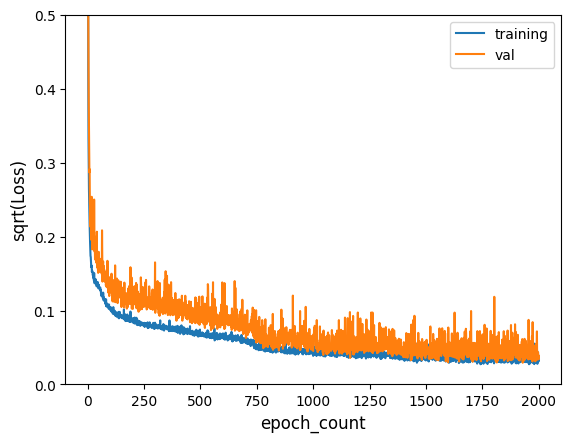

In [33]:
# Plot training process

h = history.history

training_loss = np.array(h["loss"])
test_loss = np.array(h["val_loss"])
epoch_count = np.arange(len(training_loss)) + 1

fig, ax = plt.subplots()
ax.plot(epoch_count, np.sqrt(training_loss), label='training')
ax.plot(epoch_count, np.sqrt(test_loss), label='val')
ax.set_xlabel(r'epoch_count', fontsize=12)
ax.set_ylabel(r'sqrt(Loss)', fontsize=12)
ax.legend(loc=0)
ax.set_ylim(0, 0.5)

In [34]:
# Save model
model.save('data/model.h5')